In [1]:
%load_ext autoreload
%autoreload 2


import keras
from keras.models import load_model
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.utils.eval import evaluate
from keras_retinanet.utils.gpu import setup_gpu
from keras_retinanet.models.mobilenet import custom_objects
setup_gpu('0')

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


In [2]:
classes = "D:\Amirhosein\Object_Detection\\tag-detection-RetinaNet\\tag-detection-retinanet_MobileNet\dataset\\classes.csv"
val_path = "D:\Amirhosein\Object_Detection\\tag-detection-RetinaNet\\tag-detection-retinanet_MobileNet\dataset\\val.csv"
test_path = "D:\Amirhosein\Object_Detection\\tag-detection-RetinaNet\\tag-detection-retinanet_MobileNet\dataset\\test.csv"
model_path = "D:\Amirhosein\Object_Detection\\tag-detection-RetinaNet\\tag-detection-retinanet_MobileNet\\snapshots\mobilenet_a1_s8_rdc2\mobilenet_a1_s8_rdc2_best.h5"
# model_path = "D:\Amirhosein\Object_Detection\keras-retinanet\snapshots\retinanet_resnet_09_2.h5"

test_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

    # create a generator for testing data
test_generator = CSVGenerator(
    csv_data_file=test_path,
    csv_class_file=classes,
    image_data_generator=test_image_data_generator,
    batch_size=2,
    )

from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

model = load_model(model_path, custom_objects=custom_objects)


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

c:\Users\a.pourdavoud\Anaconda3\envs\example\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output non_maximum_suppression_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to non_maximum_suppression_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [4]:
print(model.inputs)

[<tf.Tensor 'input_1:0' shape=(None, None, None, 3) dtype=float32>]


In [5]:
from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

RuntimeError: `get_session` is not available when using TensorFlow 2.0.

In [1]:
import torch

torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

NameError: name 'torch' is not defined

In [8]:

torch.cuda.get_device_name(0)


AssertionError: Torch not compiled with CUDA enabled

In [ ]:

torch.cuda.get_device_properties(0)

In [12]:
tf.train.write_graph(frozen_graph, "model", "tf_model.pb", as_text=False)

RuntimeError: `get_session` is not available when using TensorFlow 2.0.

In [7]:
import tensorflow as tf
from tensorflow.keras import optimizers
# tms = tf.saved_model.save(model, "model")
model =  freeze_session(model, keep_var_names=None, output_names=None, clear_devices=True)


AttributeError: 'Model' object has no attribute 'graph'

In [24]:
# run evaluation
logs = evaluate(
    generator=test_generator,
    model=model,
    iou_threshold=0.5,
    score_threshold=0.05,
    max_detections=100,
    save_path='output')

Parsing annotations: : 100%|██████████| 88/88 [00:00<00:00, 682.17it/s]

88 instances of class tag with:
recall_of_tag: 0.8295
precision_of_tag: 0.8391
accuracy: 0.8295
average_precision_of_tag: 0.7425
inference_time: 0.1351
mAP: 0.7425



In [298]:
from keras_retinanet.utils.visualization import draw_box, draw_caption
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import time

In [ ]:
df = pd.read_csv(test_path, header=None )
df.head()

In [ ]:
img_test = df.iloc[:][0]
img_test = img_test.values

In [295]:
def tag_search_retinanet(img, output_path):
        scale = 1.0
        bb_list = []
        label_list= [0]
        labels_to_names = {0:'tag'}
        image_path = img

        img = cv2.imread(img)
        img_scaled = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img_scaled = cv2.resize(img, None, fx=scale, fy=scale)

        start = time.time()
        _, _, detections = model.predict_on_batch(np.expand_dims(img_scaled, axis=0))
        inference_time = time.time() - start
        
        predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
        scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
        detections[:, :4] /= scale

        for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
            if score < 0.9:
                continue
            if label not in label_list:
                continue
            b = detections[0, idx, :4].astype(int)
            bb_list.append([(b[0], b[1], b[2], b[3]), score])
        
        # selected_indices = tf.image.non_max_suppression([i for i, _ in bb_list], [i for _, i in bb_list], max_output_size=2, iou_threshold=0.5)
        # selected_boxes = tf.gather([i for i, _ in bb_list], selected_indices)
        # print(selected_boxes.shape)
        # draw_boxes(img, selected_boxes, color=(100, 100, 250))
        for b, score in bb_list:
            draw_box(img, b, color=(100, 100, 250))
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(img, b, caption)

        img_name = image_path.split('\\')[-1]
        output_path = output_path + f'/output/out_{img_name}'
        cv2.imwrite(output_path, img)

In [292]:
from tqdm import tqdm as t
labels_to_names = {0: 'tag'}
output_path = "D:\Amirhosein\Object_Detection\keras-retinanet-mobilenet"
for image_path in t(img_test[3:4]):
    tag_search_retinanet(image_path, output_path)

100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


In [45]:
import matplotlib.pyplot as plt
import pickle
import os

dir = 'D:\Amirhosein\Object_Detection\\tag-detection-RetinaNet\\tag-detection-retinanet_MobileNet\snapshots\mobilenet_a1_s8_rdc2'
# dir = 'D:\Amirhosein\Object_Detection\\tag-detection-RetinaNet\\tag-detection-retinanet_MobileNet\snapshots\\0.02950\mobilenet_a1_s8_rdc2'

with open(os.path.join(dir,"train.p"), 'rb') as f:
    history = pickle.load(f)

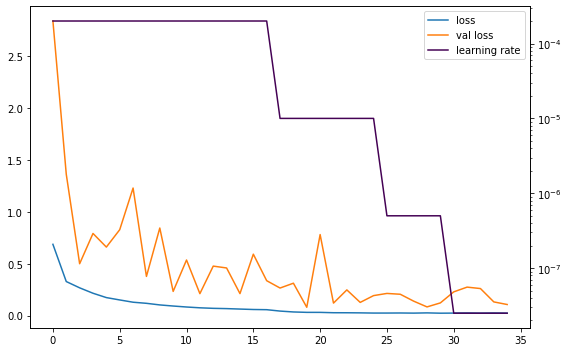

In [46]:
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
    
par1 = host.twinx()

p0, = host.plot(history["loss"], label="loss")
p1, = host.plot(history["val_loss"], label="val loss")

p2, = par1.semilogy(history["lr"], label="learning rate", color=plt.cm.viridis(0))

lns = [p0, p1, p2]
host.legend(handles=lns, loc='best')


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

# Adjust spacings w.r.t. figsize
fig.tight_layout()

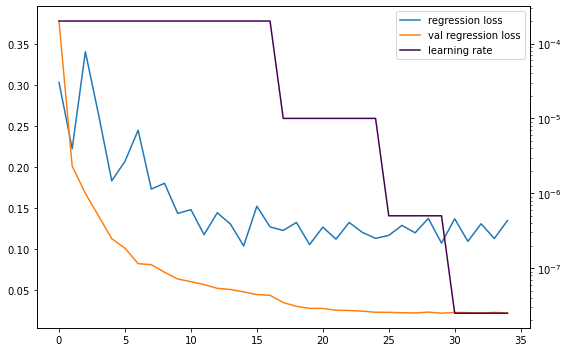

In [47]:
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
    
par1 = host.twinx()

p0, = host.plot(history["val_regression_loss"], label="regression loss")
p1, = host.plot(history["regression_loss"], label="val regression loss")

p2, = par1.semilogy(history["lr"], label="learning rate", color=plt.cm.viridis(0))

lns = [p0, p1, p2]
host.legend(handles=lns, loc='best')


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

# Adjust spacings w.r.t. figsize
fig.tight_layout()

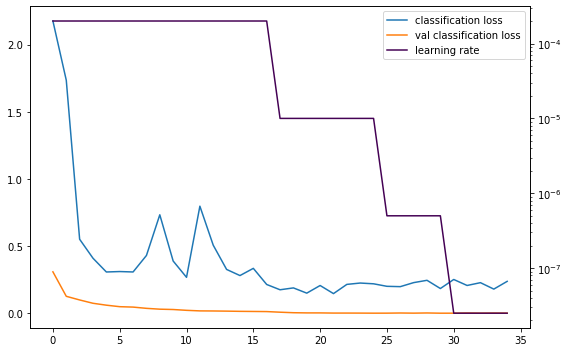

In [48]:
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
    
par1 = host.twinx()

p0, = host.plot(history["val_classification_loss"], label="classification loss")
p1, = host.plot(history["classification_loss"], label="val classification loss")

p2, = par1.semilogy(history["lr"], label="learning rate", color=plt.cm.viridis(0))

lns = [p0, p1, p2]
host.legend(handles=lns, loc='best')


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

# Adjust spacings w.r.t. figsize
fig.tight_layout()